In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [296]:
data = pd.read_csv('data.csv')
data = data.drop('overdue_day', axis=1)

In [297]:
mpl.rcParams["font.family"] = "SimHei"
mpl.rcParams["axes.unicode_minus"] = False

## 数据预处理

In [298]:
pd.set_option('display.max_columns', 20)
data.head()
# data['zmscore']
# data.info()

,zmscore,jxl_xm_score,kexin_socre,tencent_socre,jiguang_black_score,xgf,y,jg_blackscore_label,ml_feature1,ml_feature2,...,bd4,bd5,family_addr_label,bd6,bd7,bd8,bd9,bd10,bd11,bd12
0,666,359,529,42,NaN,589.0,0,0,0.0,0.0,...,0,0,1,5.0,3.0,2.0,4.0,1.0,1.0,4.0
1,672,421,616,51,42.43,751.0,0,1,1.0,0.0,...,0,0,1,5.0,2.0,1.0,4.0,2.0,1.0,4.0
2,686,521,707,16,NaN,511.0,0,0,0.0,0.0,...,0,0,1,5.0,3.0,1.0,5.0,3.0,1.0,5.0
3,695,392,850,19,NaN,775.0,0,0,0.0,0.0,...,0,0,1,4.0,3.0,2.0,3.0,1.0,2.0,3.0
4,731,398,782,19,NaN,377.0,0,0,1.0,0.0,...,0,0,1,4.0,1.0,1.0,4.0,1.0,1.0,5.0


In [299]:
 ## 查看缺失值分布
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5970 entries, 0 to 5969
Columns: 1237 entries, zmscore to bd12
dtypes: float64(1201), int64(36)
memory usage: 56.3 MB


In [300]:
# 把标签放到第一列
data_y = data.loc[:, 'y']
data_x =data.drop('y', axis=1)


In [301]:
data_x.head()

,zmscore,jxl_xm_score,kexin_socre,tencent_socre,jiguang_black_score,xgf,jg_blackscore_label,ml_feature1,ml_feature2,ml_feature3,...,bd4,bd5,family_addr_label,bd6,bd7,bd8,bd9,bd10,bd11,bd12
0,666,359,529,42,NaN,589.0,0,0.0,0.0,0.0,...,0,0,1,5.0,3.0,2.0,4.0,1.0,1.0,4.0
1,672,421,616,51,42.43,751.0,1,1.0,0.0,0.0,...,0,0,1,5.0,2.0,1.0,4.0,2.0,1.0,4.0
2,686,521,707,16,NaN,511.0,0,0.0,0.0,0.0,...,0,0,1,5.0,3.0,1.0,5.0,3.0,1.0,5.0
3,695,392,850,19,NaN,775.0,0,0.0,0.0,0.0,...,0,0,1,4.0,3.0,2.0,3.0,1.0,2.0,3.0
4,731,398,782,19,NaN,377.0,0,1.0,0.0,0.0,...,0,0,1,4.0,1.0,1.0,4.0,1.0,1.0,5.0


In [302]:
# 判断标签无空值
data_y.isnull().any()

False

In [303]:
# 取出列标签
col = data_x.columns

In [304]:
col[:10]

Index(['zmscore', 'jxl_xm_score', 'kexin_socre', 'tencent_socre',
       'jiguang_black_score', 'xgf', 'jg_blackscore_label', 'ml_feature1',
       'ml_feature2', 'ml_feature3'],
      dtype='object')

In [305]:
# 由于此数据集缺失值太多，无法甄别填充，所以使用xgboost进行训练，但是却发现feature_importances_(特征相关性只有两列overdue_day': 0.97727275,
#  'xgf': 0.022727273,有值，似乎xgboost算法不适合次数据集，所以只能采用暴力填充空值为0，在比较各算法优越性。)
data_x.fillna(0, inplace=True)

In [306]:
# 标准化数据
std = StandardScaler()

In [307]:
data_x = std.fit_transform(data_x)

D:\anaconda\envs\p36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\anaconda\envs\p36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [308]:
# 标准化后的数据， 不含y标签
data_x[:10, :10]

array([[ 0.68422113, -0.80103955, -1.00040131, -0.03368504, -0.27981895,
         0.03741564, -0.29367421, -0.43610938, -0.18521213, -0.35793563],
       [ 0.83295943,  0.08270644, -0.23225546,  0.39581125,  1.53263963,
         1.19131113,  3.40513388,  2.29300276, -0.18521213, -0.35793563],
       [ 1.18001548,  1.5081032 ,  0.57120745, -1.27445213, -0.27981895,
        -0.51816367, -0.29367421, -0.43610938, -0.18521213, -0.35793563],
       [ 1.40312294, -0.33065862,  1.83379201, -1.13128669, -0.27981895,
         1.36225861, -0.29367421, -0.43610938, -0.18521213, -0.35793563],
       [ 2.29555279, -0.24513482,  1.23340215, -1.13128669, -0.27981895,
        -1.47262043, -0.29367421,  2.29300276, -0.18521213, -0.35793563],
       [ 0.73380056, -0.50170623, -0.48830407, -1.13128669, -0.27981895,
         0.38643341, -0.29367421,  2.29300276, -0.18521213, -0.35793563],
       [ 0.28758564, -4.49281716,  1.83379201, -1.22673032, -0.27981895,
         0.27959124, -0.29367421, -0.43610938

In [309]:
# 把标签重新加上
data_x = pd.DataFrame(data_x, columns=col)
data_x.head()
data.shape

(5970, 1237)

In [310]:
# 使用随机森林（feature_importances_）进行相关性特征分析
rf = RandomForestClassifier()
xgb = XGBClassifier()
gbdt = GradientBoostingClassifier()

In [311]:
rf.fit(data_x, data_y)
# xgb.fit(data_x, data_y)
# data_x.head()
# data_y.head()

D:\anaconda\envs\p36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [312]:
feature = rf.feature_importances_

In [313]:
# 特征与相关性组合成字典的形式
dic_item = dict(zip(col, feature))
dic_item

{'zmscore': 0.009843585732993983,
 'jxl_xm_score': 0.00691499336470007,
 'kexin_socre': 0.011310034316443906,
 'tencent_socre': 0.01261430243010057,
 'jiguang_black_score': 0.014124927828665364,
 'xgf': 0.019357079615043165,
 'jg_blackscore_label': 0.0020500530374410885,
 'ml_feature1': 0.0,
 'ml_feature2': 0.0,
 'ml_feature3': 0.0001703720609812493,
 'ml_feature4': 7.108510026552989e-05,
 'ml_feature5': 0.0006681301914497946,
 'ml_feature6': 0.00042301604628966743,
 'ml_feature7': 0.0004639266853787863,
 'ml_feature50': 0.0011029635494306795,
 'ml_feature8': 0.0013772742182631128,
 'ml_feature9': 0.0001681316144415723,
 'ml_feature10': 0.0013690780504608487,
 'ml_feature11': 0.001309494241366408,
 'ml_feature12': 0.002499870561092711,
 'ml_feature13': 0.0005948461630420436,
 'ml_feature14': 0.004610443622904242,
 'ml_feature15': 0.0010460910004317977,
 'ml_feature16': 0.0007418999257648662,
 'ml_feature17': 0.0,
 'ml_feature18': 0.002016476243071631,
 'ml_feature19': 0.004732392630931

In [314]:
# 提取出相关性大于0的特征
col_new = []
for k, v in dic_item.items():
    if v > 0:
        col_new.append(k)

In [315]:
# 绘制前十个相关性最大的特征相关程度
# 对字典按值排序
dict_10 = sorted(dic_item.items(), key=lambda x:x[1], reverse=True)[:10]
dict_10

[('xgf', 0.019357079615043165),
 ('_COL26', 0.015066516524717253),
 ('jiguang_black_score', 0.014124927828665364),
 ('tencent_socre', 0.01261430243010057),
 ('kexin_socre', 0.011310034316443906),
 ('zmscore', 0.009843585732993983),
 ('bd1', 0.008050387342722823),
 ('_COL11', 0.008046419045591089),
 ('_COL14', 0.007615276815840126),
 ('ml_feature44', 0.0074074538880195065)]

In [316]:
k_10 = []
v_10 = []
for k, v in dict_10:
    k_10.append(k)
    v_10.append(v)


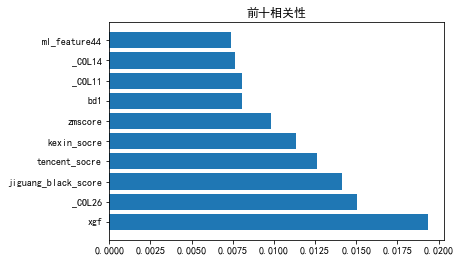

In [317]:
plt.barh(k_10, v_10,)
plt.title('前十相关性')

plt.show()

In [318]:
data_x = data_x[col_new]
# 可以看出overdue_day (逾期天数)相关性远远大于其他特征

In [319]:
data_x.head()

,zmscore,jxl_xm_score,kexin_socre,tencent_socre,jiguang_black_score,xgf,jg_blackscore_label,ml_feature3,ml_feature4,ml_feature5,...,bd4,bd5,family_addr_label,bd6,bd7,bd8,bd9,bd10,bd11,bd12
0,0.684221,-0.801040,-1.000401,-0.033685,-0.279819,0.037416,-0.293674,-0.357936,-0.110488,-0.487667,...,-0.167262,-0.277697,0.316956,1.421785,1.504949,0.606964,0.918124,0.011010,-0.001215,0.803252
1,0.832959,0.082706,-0.232255,0.395811,1.532640,1.191311,3.405134,-0.357936,-0.110488,-0.487667,...,-0.167262,-0.277697,0.316956,1.421785,0.637966,-0.167139,0.918124,1.022227,-0.001215,0.803252
2,1.180015,1.508103,0.571207,-1.274452,-0.279819,-0.518164,-0.293674,-0.357936,-0.110488,-0.487667,...,-0.167262,-0.277697,0.316956,1.421785,1.504949,-0.167139,1.453450,2.033443,-0.001215,1.299363
3,1.403123,-0.330659,1.833792,-1.131287,-0.279819,1.362259,-0.293674,-0.357936,-0.110488,-0.487667,...,-0.167262,-0.277697,0.316956,0.894282,1.504949,0.606964,0.382798,0.011010,0.905850,0.307140
4,2.295553,-0.245135,1.233402,-1.131287,-0.279819,-1.472620,-0.293674,-0.357936,-0.110488,-0.487667,...,-0.167262,-0.277697,0.316956,0.894282,-0.229017,-0.167139,0.918124,0.011010,-0.001215,1.299363


In [320]:
# 0的个数为5163个， 1的个数为807个，样本不均衡
data_y.value_counts()

0    5163
1     807
Name: y, dtype: int64

In [321]:
# 解决样本不均衡问题
# 合并y到data_x
data_y.name = 'y'
data_combin = pd.concat((data_x, data_y), axis=1)

In [322]:
data_combin['y']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      1
24      0
25      0
26      0
27      0
28      0
29      0
       ..
5940    0
5941    0
5942    1
5943    1
5944    0
5945    0
5946    0
5947    0
5948    1
5949    0
5950    0
5951    0
5952    0
5953    1
5954    0
5955    0
5956    0
5957    0
5958    0
5959    0
5960    0
5961    0
5962    0
5963    0
5964    0
5965    0
5966    0
5967    1
5968    0
5969    0
Name: y, Length: 5970, dtype: int64

In [323]:
data_1 = data_combin[data_combin['y'] == 1]
data_1.head()
type(data_1)
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 23 to 5967
Columns: 802 entries, zmscore to y
dtypes: float64(801), int64(1)
memory usage: 4.9 MB


In [324]:
# data_1['y'].value_counts()[1]
# data_combin[data_combin['y'] == 0]

In [325]:
data_0 = data_combin[data_combin['y'] == 0].iloc[:data_1['y'].value_counts()[1], :]

In [326]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 807 entries, 0 to 911
Columns: 802 entries, zmscore to y
dtypes: float64(801), int64(1)
memory usage: 4.9 MB


In [327]:
data_new = pd.concat([data_1, data_0])
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 23 to 911
Columns: 802 entries, zmscore to y
dtypes: float64(801), int64(1)
memory usage: 9.9 MB


In [328]:
data_new = data_new.reset_index(drop=True)

In [329]:
# 打乱数据
data_new = data_new.sample(frac=1).reset_index(drop=True)

In [330]:
data_new.isnull().any().all()

False

In [331]:
data_y = data_new['y']
data_x = data_new.drop('y', axis=1)

In [332]:
# 切分数据集
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=1)

## 模型选择

In [333]:
# 绘制roc曲线

In [334]:
rf = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
gbdt = GradientBoostingClassifier(random_state=1)
logist = LogisticRegression(random_state=1)

D:\anaconda\envs\p36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.         0.         0.0233463  0.05836576 0.11284047 0.23346304
 0.40856031 0.56031128 0.71984436 0.86381323 0.9766537  1.        ] [0.         0.01754386 0.10087719 0.22807018 0.39035088 0.59649123
 0.74122807 0.87719298 0.95614035 0.97807018 0.99561404 1.        ] [2.  1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ]
0.7435405147109018
[0.         0.         0.         0.0077821  0.0077821  0.01167315
 0.01167315 0.0155642  0.0155642  0.01945525 0.01945525 0.02723735
 0.02723735 0.0311284  0.0311284  0.03891051 0.03891051 0.04280156
 0.04280156 0.04669261 0.04669261 0.05447471 0.05447471 0.05836576
 0.05836576 0.06225681 0.06225681 0.06614786 0.06614786 0.07392996
 0.07392996 0.07782101 0.07782101 0.08171206 0.08171206 0.08560311
 0.08560311 0.08949416 0.08949416 0.09338521 0.09338521 0.09727626
 0.09727626 0.10116732 0.10116732 0.11284047 0.11284047 0.12451362
 0.12451362 0.12840467 0.12840467 0.13618677 0.13618677 0.14785992
 0.14785992 0.15175097 0.15175097 0.15564202 0.15564202 0.

D:\anaconda\envs\p36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.         0.         0.         0.00389105 0.00389105 0.0077821
 0.0077821  0.01945525 0.01945525 0.0233463  0.0233463  0.02723735
 0.02723735 0.0311284  0.0311284  0.03891051 0.03891051 0.04280156
 0.04280156 0.04669261 0.04669261 0.05447471 0.05447471 0.06225681
 0.06225681 0.06614786 0.06614786 0.07392996 0.07392996 0.08171206
 0.08171206 0.08560311 0.08560311 0.08949416 0.08949416 0.09338521
 0.09338521 0.11284047 0.11284047 0.11673152 0.11673152 0.12062257
 0.12062257 0.12451362 0.12451362 0.12840467 0.12840467 0.13229572
 0.13229572 0.13618677 0.13618677 0.14007782 0.14007782 0.14396887
 0.14396887 0.14785992 0.14785992 0.15564202 0.15564202 0.15953307
 0.15953307 0.16731518 0.16731518 0.17509728 0.17509728 0.17898833
 0.17898833 0.18287938 0.18287938 0.18677043 0.18677043 0.19066148
 0.19066148 0.19455253 0.19455253 0.20233463 0.20233463 0.21011673
 0.21011673 0.21789883 0.21789883 0.22957198 0.22957198 0.23346304
 0.23346304 0.23735409 0.23735409 0.24124514 0.24124514 0.25291

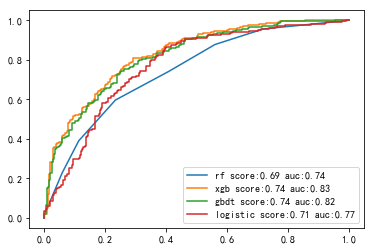

In [335]:
# %matplotlib tk
model_names = ['rf', 'xgb', 'gbdt', 'logistic']
# model_names = ['xgb', 'gbdt', 'logistic']
models = [rf, xgb, gbdt, logist]
# models = [xgb, gbdt, logist]
for index, model in enumerate(models):
    model.fit(x_train, y_train)
    pre_score = model.score(x_test, y_test)
    # re_call = recall_score()
    proba = model.predict_proba(x_test)[:, -1]
    fpr, tpr, thresholds = roc_curve(y_test, proba)
    print(fpr, tpr, thresholds)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.plot(fpr, tpr, label='%s score:%.2f auc:%.2f'% (model_names[index], pre_score, roc_auc))
    plt.legend()
plt.show()

In [ ]:
# 通过上图可知各模型评分相差不多，都有高度的准确率及泛化性能

0.6144329896907217
thresholds: [2.  1.  0.8 0.6 0.4 0.2 0. ]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-----------


D:\anaconda\envs\p36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\anaconda\envs\p36\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.709278350515464
thresholds: [2.00000000e+00 1.00000000e+00 9.99999455e-01 9.99999383e-01
 9.99998105e-01 9.99996736e-01 9.99993262e-01 9.99987060e-01
 9.99984349e-01 9.99963126e-01 9.99946531e-01 9.99929750e-01
 9.99897950e-01 9.99888755e-01 9.99762089e-01 9.99752604e-01
 9.99718910e-01 9.99703017e-01 9.99641690e-01 9.99609064e-01
 9.99572391e-01 9.99516586e-01 9.99485370e-01 9.99419318e-01
 9.99163710e-01 9.99117313e-01 9.98936547e-01 9.98662459e-01
 9.98275052e-01 9.98204001e-01 9.95649735e-01 9.95500483e-01
 9.94392886e-01 9.94209409e-01 9.94175830e-01 9.93549829e-01
 9.93509190e-01 9.93008916e-01 9.92364433e-01 9.91986185e-01
 9.91907627e-01 9.90166108e-01 9.89333598e-01 9.89076055e-01
 9.86581904e-01 9.86089204e-01 9.84664968e-01 9.84471402e-01
 9.82902635e-01 9.79250533e-01 9.64323425e-01 9.63113874e-01
 9.61749328e-01 9.57447470e-01 9.42991479e-01 9.40804639e-01
 9.28170273e-01 9.27701577e-01 9.16902038e-01 9.12351192e-01
 9.09086215e-01 9.06814503e-01 8.61125426e-01 8.5874907

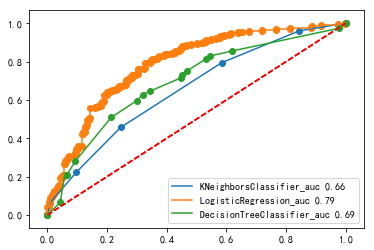

In [336]:
models = [KNeighborsClassifier(), LogisticRegression(max_iter=10, penalty='l1'), DecisionTreeClassifier(max_depth=5)]
models_names = ['KNeighborsClassifier_auc', 'LogisticRegression_auc', 'DecisionTreeClassifier_auc']
for index, model in enumerate(models):
    clf = model
    clf.fit(x_train, y_train)
    pre = clf.predict(x_test)
    score = clf.score(x_test, y_test)
#     print(pre)
    print(score)

# 绘图
    proba_1 = clf.predict_proba(x_test)[:, -1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_1)
#     print('fpr:', fpr)
#     print('tpr:', tpr)
    print('thresholds:', thresholds)
    print(type(fpr), type(tpr))
    print('-----------')

    roc_auc = auc(fpr, tpr)
    # 绘制roc
    plt.plot(fpr, tpr, label='%s %.2f' % (models_names[index], roc_auc))
    plt.scatter(fpr, tpr)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [35]:
# 通过上图可知只有决策树泛化性能比较差，其余都很高

In [36]:
# 最后选择xgboost进行预测

## 模型调参

In [337]:
# 数的最大深度max_depth：3
params = {'max_depth': range(3, 11, 2)}
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=params, scoring='roc_auc')
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

D:\anaconda\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 3}
0.8554978152989913


In [338]:
# 最小叶子节点权重和min_child_weight: 5
params = {'min_child_weight': range(3, 12, 2), }
grid_search = GridSearchCV(estimator=XGBClassifier(max_depth=3, eta=0.1, subsample=0.8, colsample_bytree=0.8, random_state=1), param_grid=params, scoring='roc_auc')
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

D:\anaconda\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'min_child_weight': 5}
0.8554370036170494


In [339]:
params = {'n_estimators': range(100, 150, 10)}
grid_search = GridSearchCV(estimator=XGBClassifier(max_depth=3, eta=0.1, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, random_state=1), param_grid=params, scoring='roc_auc')
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

D:\anaconda\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 110}
0.8597855357392223


In [361]:
xgb_1 = XGBClassifier(max_depth=3, eta=0.1, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, random_state=1, n_estimators=110)

[0.         0.         0.         0.00389105 0.00389105 0.0077821
 0.0077821  0.01167315 0.01167315 0.0155642  0.0155642  0.0233463
 0.0233463  0.02723735 0.02723735 0.0311284  0.0311284  0.03501946
 0.03501946 0.04280156 0.04280156 0.05058366 0.05058366 0.05836576
 0.05836576 0.06225681 0.06225681 0.07003891 0.07003891 0.08560311
 0.08560311 0.08949416 0.08949416 0.09338521 0.09338521 0.09727626
 0.09727626 0.10116732 0.10116732 0.10505837 0.10505837 0.10894942
 0.10894942 0.12062257 0.12062257 0.12840467 0.12840467 0.13618677
 0.13618677 0.14007782 0.14007782 0.14396887 0.14396887 0.15175097
 0.15175097 0.15564202 0.15564202 0.15953307 0.15953307 0.16342412
 0.16342412 0.16731518 0.16731518 0.17509728 0.17509728 0.17898833
 0.17898833 0.18287938 0.18287938 0.18677043 0.18677043 0.20233463
 0.20233463 0.20622568 0.20622568 0.21789883 0.21789883 0.22178988
 0.22178988 0.22568093 0.22568093 0.22957198 0.22957198 0.23346304
 0.23346304 0.23735409 0.23735409 0.24902724 0.24902724 0.256809

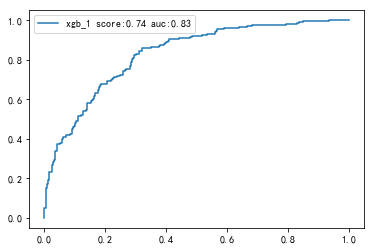

In [362]:
xgb_1.fit(x_train, y_train)
pre_score = xgb_1.score(x_test, y_test)
# re_call = recall_score()
proba = xgb_1.predict_proba(x_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
print(fpr, tpr, thresholds)
# 输出混淆矩阵
pre = xgb_1.predict(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, pre).ravel()
confusion_matrix(y_test, pre)

roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, label='%s score:%.2f auc:%.2f'% ('xgb_1', pre_score, roc_auc))
plt.legend()
plt.show()